## Imports and constants

to do: 

transformers, features generation,
fix left bisect as described in the changed rules

In [1]:
SPLIT_SEED = 42
KFOLD_SPLITS = 3

IS_EMBEDDING_USED = True
if (IS_EMBEDDING_USED):
    FAISS_ITERATIONS = 5
    
IS_NOTEBOOK_ON_KAGGLE = True
if (IS_NOTEBOOK_ON_KAGGLE):
    LOCAL_DATA_PATH = '/kaggle/input/mts-ml-cookies'
    DATA_FILE = 'dataset_full.feather'
    TARGET_FILE = 'target_train.feather'
    SUBMISSION_FILE = 'submission.feather'
    
IS_MODEL_CATBOOST = True
IS_MODEL_RANDFOREST = False
if (IS_MODEL_RANDFOREST):
    MAX_DEPTH = 10

In [2]:
import sys
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [3]:
!pip install feather-format >> none -q
!pip install faiss-cpu --no-cache -q
!pip install polars -q

import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pyarrow as pa
import polars as pl

%matplotlib inline
sns.set_style('darkgrid')

## Showing data

In [4]:
id_to_submit = pd.read_feather(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}')

In [5]:
display(id_to_submit.head(3))
id_to_submit.info

,user_id
0,221301
1,31271
2,211594


<bound method DataFrame.info of         user_id
0        221301
1         31271
2        211594
3        253119
4        192578
...         ...
144719   415284
144720   415285
144721   415286
144722   415306
144723   415315

[144724 rows x 1 columns]>

In [6]:
data = pd.read_feather(f'{LOCAL_DATA_PATH}/{DATA_FILE}')

In [7]:
display(data.head())
data.describe()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098


,price,request_cnt,user_id
count,3.163100e+08,3.228994e+08,3.228994e+08
mean,3.308510e+04,1.724197e+00,2.070983e+05
std,2.583592e+04,1.213835e+00,1.200584e+05
min,9.000000e+01,1.000000e+00,0.000000e+00
25%,1.397400e+04,1.000000e+00,1.027880e+05
50%,2.199000e+04,1.000000e+00,2.068870e+05
75%,4.999000e+04,2.000000e+00,3.113950e+05
max,1.956570e+05,1.600000e+01,4.153160e+05


In [8]:
for column in data.columns:
    if column != "date" and column !="price" and column !="user_id" and column !="request_cnt":
        print(type(data[column]))
        data[column] = data[column].cat.codes
    elif column == "date":
        data["date"] = pd.to_datetime(data["date"])

data.head()

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,21,409,1,589,5788,2,2,20368.0,2022-06-15,2,1,45098
1,21,409,1,589,12900,2,2,20368.0,2022-06-19,2,1,45098
2,21,409,1,589,17626,2,2,20368.0,2022-06-12,0,1,45098
3,21,409,1,589,59366,2,2,20368.0,2022-05-16,0,1,45098
4,21,409,1,589,59366,2,2,20368.0,2022-05-30,0,1,45098


In [9]:
data = pl.from_pandas(data)

In [10]:
data.select(['cpe_type_cd']).to_pandas()['cpe_type_cd'].value_counts()

2    322781599
3        53768
1        36116
0        27952
Name: cpe_type_cd, dtype: int64

In [11]:
data['cpe_type_cd'].value_counts()

cpe_type_cd,counts
i8,u32
0,27952
3,53768
2,322781599
1,36116


In [12]:
targets = pd.read_feather(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')
targets.head()

,age,is_male,user_id
0,31.0,1,350459
1,35.0,1,188276
2,41.0,0,99002
3,33.0,0,155506
4,54.0,0,213873


In [13]:
targets = pa.Table.from_pandas(targets)
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64


## Counting users <-> items embedding

In [14]:
%%time
if (IS_EMBEDDING_USED):
    data_agg = data.groupby(['user_id', 'url_host'], maintain_order=True).agg(
        pl.sum("request_cnt")
    )
    url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
    print(f'{len(url_set)} urls')
    url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
    usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
    print(f'{len(usr_set)} users')
    usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

199683 urls
415317 users
CPU times: user 58.6 s, sys: 18.6 s, total: 1min 17s
Wall time: 31.2 s


In [15]:
%%time
if (IS_EMBEDDING_USED):
    values = np.array(data_agg['request_cnt'].to_pandas())
    rows = np.array(data_agg['user_id'].to_pandas().map(usr_dict))
    cols = np.array(data_agg['url_host'].to_pandas().map(url_dict))
    mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    als = implicit.approximate_als.FaissAlternatingLeastSquares(
        factors = 50, iterations = FAISS_ITERATIONS, use_gpu = False, calculate_training_loss = True, regularization = 0.1
    )

CPU times: user 1.57 s, sys: 239 ms, total: 1.81 s
Wall time: 1.81 s


In [16]:
%%time
if (IS_EMBEDDING_USED):
    als.fit(mat)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 3min 20s, sys: 2.47 s, total: 3min 22s
Wall time: 55.8 s


In [17]:
if (IS_EMBEDDING_USED):
    u_factors = als.user_factors 
    print(len(u_factors))

199683


In [18]:
if (IS_EMBEDDING_USED):
    d_factors = als.item_factors
    print(len(d_factors))

415317


## Sex prediction

In [19]:
id_to_submit = pd.read_feather(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}')

In [20]:
if (IS_EMBEDDING_USED):
    inv_usr_map = {v: k for k, v in usr_dict.items()}
    usr_emb = pd.DataFrame(d_factors)
    usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
    usr_targets = targets.to_pandas()
    df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
    df = df[df['is_male'] != 'NA']
    df = df.dropna()
    df['is_male'] = df['is_male'].map(int)
    print(df['is_male'].value_counts())

1    135314
0    128982
Name: is_male, dtype: int64


#### Model trainings

In [21]:
max_gini = 0
train_index = 0
test_index = 0

if (IS_MODEL_CATBOOST):
    clf = CatBoostClassifier()
elif (IS_MODEL_RANDFOREST):
    clf = RandomForestClassifier(max_depth=MAX_DEPTH, random_state=SPLIT_SEED)

In [22]:
%%time
if (IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST):
    x = df.drop(['user_id', 'age', 'is_male'], axis = 1)
    y = df['is_male']

    kf = KFold(n_splits=KFOLD_SPLITS)

    for train_index, test_index in kf.split(x):
        print("Train indexes: ", train_index[:5],
              "; Test indexes: ", test_index[:5], ";\n",
              "Train length: ", len(train_index), 
              "; Test length: ", len(test_index), 
              "; Dataset length: ", len(x), ';', sep='', end='\n')
        
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if (IS_MODEL_CATBOOST):
            clf.fit(x_train, y_train, verbose = False)
        elif (IS_MODEL_RANDFOREST):
            clf.fit(x_train, y_train)
        
        gini = float(f'{2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')
        if gini > max_gini:
            max_gini = gini
            max_train_index = train_index
            max_test_index = test_index
        
        print(f'Current GINI is {gini}, current max is {max_gini}', end="\n\n")

Train indexes: [88099 88100 88101 88102 88103]; Test indexes: [0 1 2 3 4];
Train length: 176197; Test length: 88099; Dataset length: 264296;
Current GINI is 0.651, current max is 0.651

Train indexes: [0 1 2 3 4]; Test indexes: [88099 88100 88101 88102 88103];
Train length: 176197; Test length: 88099; Dataset length: 264296;
Current GINI is 0.647, current max is 0.651

Train indexes: [0 1 2 3 4]; Test indexes: [176198 176199 176200 176201 176202];
Train length: 176198; Test length: 88098; Dataset length: 264296;
Current GINI is 0.646, current max is 0.651

CPU times: user 8min 41s, sys: 16.2 s, total: 8min 57s
Wall time: 2min 24s


In [23]:
print(f'Max GINI is {max_gini}')
print(f'Max train index is {max_train_index[:5]}')
print(f'Max test index is {max_test_index[:5]}')

Max GINI is 0.651
Max train index is [88099 88100 88101 88102 88103]
Max test index is [0 1 2 3 4]


In [24]:
id_to_submit.merge(usr_emb, how = 'left', on = ['user_id'])

,user_id,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,221301,0.029245,0.035005,-0.006490,0.026633,-0.014702,0.020151,-0.000573,0.020823,0.026260,...,-0.025529,0.019367,-0.008969,0.027808,0.016783,-0.001517,-0.010127,-0.004781,-0.005754,0.001662
1,31271,0.006095,0.019409,0.010669,-0.005106,0.008963,-0.004752,-0.003487,0.022913,-0.001091,...,0.001498,-0.019843,-0.007616,0.004185,0.018323,-0.004472,-0.020129,0.018903,-0.003352,-0.003521
2,211594,0.003681,-0.003291,0.004470,0.002782,0.006455,-0.002227,-0.001372,-0.004351,-0.000942,...,0.003315,-0.012787,0.003676,0.001498,0.010279,0.007279,-0.011304,0.002038,-0.003773,-0.007728
3,253119,0.001906,0.007806,0.016303,-0.007532,0.011521,-0.005431,0.002999,0.027841,-0.010114,...,0.008362,-0.021413,-0.010908,0.001185,0.022150,-0.012494,-0.029974,0.027783,-0.006921,-0.001592
4,192578,0.041704,0.030610,0.017016,0.012115,-0.004594,0.003035,0.008717,0.044576,-0.007410,...,-0.019392,-0.004878,0.023981,0.017782,0.034749,-0.042412,-0.046539,0.033663,-0.003493,0.009650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144719,415284,-0.000045,-0.002972,0.006562,-0.002032,0.003942,-0.001617,0.003576,0.009293,-0.006881,...,0.002659,-0.008118,-0.001038,0.000211,0.007218,-0.009937,-0.012779,0.011944,-0.002591,-0.000292
144720,415285,0.002499,0.008064,0.004380,-0.002109,0.003805,-0.001945,-0.001447,0.009596,-0.000403,...,0.000591,-0.008290,-0.003248,0.001791,0.007624,-0.001804,-0.008335,0.007806,-0.001397,-0.001477
144721,415286,0.000899,0.002772,0.001484,-0.000720,0.001312,-0.000694,-0.000508,0.003299,-0.000140,...,0.000185,-0.002884,-0.001048,0.000653,0.002624,-0.000648,-0.002890,0.002690,-0.000450,-0.000532
144722,415306,0.001691,0.005210,0.002784,-0.001352,0.002454,-0.001253,-0.000931,0.006194,-0.000279,...,0.000318,-0.005416,-0.001995,0.001212,0.004917,-0.001235,-0.005389,0.005074,-0.000855,-0.000997


In [25]:
if (IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST):
    if (IS_MODEL_CATBOOST):
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index], verbose = False)
    elif (IS_MODEL_RANDFOREST):
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index])
    id_to_submit['user_id'].unique
    #id_to_submit['is_male'] = clf.predict_proba(id_to_submit.merge(usr_emb, how = 'left', on = ['user_id']))[:,1]

idk absolutely how does it work, have to check later

In [26]:
#id_to_submit['is_male'] = clf.predict_proba(id_to_submit.merge(usr_emb, how = 'left', on = ['user_id']))[:,1]
#id_to_submit['is_male'] = clf.predict(id_to_submit.merge(usr_emb, how = 'left', on = ['user_id']))
id_to_submit['is_male'] = clf.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'left', on = ['user_id']))

In [27]:
print("Current GINI score: ", float(f'{2 * m.roc_auc_score(y.iloc[max_test_index], clf.predict_proba(x.iloc[max_test_index])[:,1]) - 1:2.3f}'))

Current GINI score:  0.651


## Age prediction

In [28]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

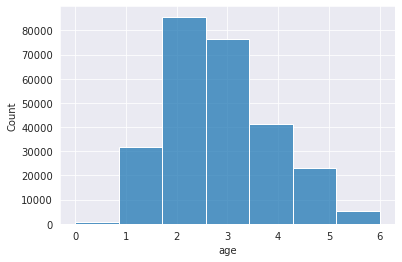

In [29]:
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

In [30]:
max_f1 = 0
train_index = 0
test_index = 0

if (IS_MODEL_CATBOOST):
    clf = CatBoostClassifier()
elif (IS_MODEL_RANDFOREST):
    clf = RandomForestClassifier(max_depth=MAX_DEPTH, random_state=SPLIT_SEED)

In [31]:
if (IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST):
    x = df.drop(['user_id', 'age', 'is_male'], axis = 1)
    y = df['age']

    kf = KFold(n_splits=KFOLD_SPLITS)

    for train_index, test_index in kf.split(x):
        print("Train indexes: ", train_index[:5],
              "; Test indexes: ", test_index[:5], ";\n",
              "Train length: ", len(train_index), 
              "; Test length: ", len(test_index), 
              "; Dataset length: ", len(x), ';', sep='', end='\n')
        
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if (IS_MODEL_CATBOOST):
            clf.fit(x_train, y_train, verbose = False)
        elif (IS_MODEL_RANDFOREST):
            clf.fit(x_train, y_train)
        
        f1 = m.f1_score(y_test, clf.predict(x_test), average='weighted')
        if f1 > max_f1:
            max_f1 = f1
            max_train_index = train_index
            max_test_index = test_index
        
        print(f'Current F1 is {f1}, current max is {max_f1}', end="\n\n")

Train indexes: [88099 88100 88101 88102 88103]; Test indexes: [0 1 2 3 4];
Train length: 176197; Test length: 88099; Dataset length: 264296;
Current F1 is 0.39858313396285416, current max is 0.39858313396285416

Train indexes: [0 1 2 3 4]; Test indexes: [88099 88100 88101 88102 88103];
Train length: 176197; Test length: 88099; Dataset length: 264296;
Current F1 is 0.39672571817010677, current max is 0.39858313396285416

Train indexes: [0 1 2 3 4]; Test indexes: [176198 176199 176200 176201 176202];
Train length: 176198; Test length: 88098; Dataset length: 264296;
Current F1 is 0.3962085213839013, current max is 0.39858313396285416



In [32]:
print(f'Max F1 is {max_f1}')
print(f'Max train index is {max_train_index[:5]}')
print(f'Max test index is {max_test_index[:5]}')

Max F1 is 0.39858313396285416
Max train index is [88099 88100 88101 88102 88103]
Max test index is [0 1 2 3 4]


In [33]:
if (IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST):
    if (IS_MODEL_CATBOOST):
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index], verbose = False)
    elif (IS_MODEL_RANDFOREST):
        clf.fit(x.iloc[max_train_index], y.iloc[max_train_index])
    id_to_submit['age'] = clf.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'left', on = ['user_id']))

In [34]:
if (IS_MODEL_CATBOOST or IS_MODEL_RANDFOREST):
    print(m.classification_report(
          y.iloc[max_test_index], 
          clf.predict(x.iloc[max_test_index]), 
          target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']
    ))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       262
       18-25       0.48      0.26      0.34     10590
       25-34       0.46      0.62      0.53     28502
       35-44       0.39      0.51      0.44     25545
       45-54       0.36      0.18      0.24     13708
       55-65       0.40      0.18      0.25      7695
         65+       0.37      0.01      0.02      1797

    accuracy                           0.42     88099
   macro avg       0.35      0.25      0.26     88099
weighted avg       0.42      0.42      0.40     88099



## Submission

In [35]:
display(id_to_submit.head())
display(id_to_submit.is_male.value_counts())
display(id_to_submit.age.value_counts())
id_to_submit.to_csv('submission.csv', index = False)

,user_id,is_male,age
0,221301,1,2
1,31271,1,3
2,211594,1,2
3,253119,0,2
4,192578,1,2


1    73975
0    70749
Name: is_male, dtype: int64

2    62999
3    55784
4    10757
1     9332
5     5754
6       98
Name: age, dtype: int64

In [36]:
print(f'Score: {max_gini + 2*max_f1}')

Score: 1.4481662679257084
